In [2]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201, ResNet152V2, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import zipfile

In [3]:
# Ensure the dataset is extracted from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define paths to dataset
zip_path = '/content/drive/MyDrive/Dataset/SkinDisease.zip'
extract_path = '/content/skin_disease_dataset'

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print('Dataset extracted successfully.')

Dataset extracted successfully.


In [5]:
data_dir_train = os.path.join(extract_path, 'SkinDisease/train')
data_dir_test = os.path.join(extract_path, 'SkinDisease/test')

In [6]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for training and validation
)


In [7]:
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


Found 11128 images belonging to 22 classes.


In [8]:
validation_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2770 images belonging to 22 classes.


In [9]:
# Fusion Model Development
input_shape = (256, 256, 3)
input_tensor = Input(shape=input_shape, name="input_image")

In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# InceptionV3 Model
input_tensor_inception = Input(shape=input_shape, name="input_inception")
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor_inception)
base_model_inception.trainable = False  # Freeze layers
x_inception = base_model_inception.output
x_inception = GlobalAveragePooling2D()(x_inception)
x_inception = Dense(512, activation='relu')(x_inception)
output_inception = Dense(train_generator.num_classes, activation='softmax')(x_inception)

# Create the InceptionV3 model
model_inception = Model(inputs=input_tensor_inception, outputs=output_inception)

# Compile the model
model_inception.compile(optimizer=Adam(),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-5, verbose=1)
# Train the InceptionV3 model
history_inception = model_inception.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[reduce_lr]
)

# Save the InceptionV3 model
model_inception.save('/content/drive/MyDrive/inception_model.h5')


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


348/348 ━━━━━━━━━━━━━━━━━━━━ 316s 842ms/step - accuracy: 0.3032 - loss: 2.4274 - val_accuracy: 0.3220 - val_loss: 2.3304 - learning_rate: 0.0010
Epoch 2/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 273s 738ms/step - accuracy: 0.4355 - loss: 1.8413 - val_accuracy: 0.3079 - val_loss: 2.2713 - learning_rate: 0.0010
Epoch 3/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 258s 726ms/step - accuracy: 0.4806 - loss: 1.6906 - val_accuracy: 0.3433 - val_loss: 2.3512 - learning_rate: 0.0010
Epoch 4/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 263s 734ms/step - accuracy: 0.4971 - loss: 1.5977 - val_accuracy: 0.3473 - val_loss: 2.3237 - learning_rate: 0.0010
Epoch 5/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 257s 728ms/step - accuracy: 0.5243 - loss: 1.5296 - val_accuracy: 0.3422 - val_loss: 2.4047 - learning_rate: 0.0010
Epoch 6/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 262s 725ms/step - accuracy: 0.5555 - loss: 1.4125 - val_accuracy: 0.3545 - val_loss: 2.3131 - learning_rate: 0.0010
Epoch 7/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.5704 - 

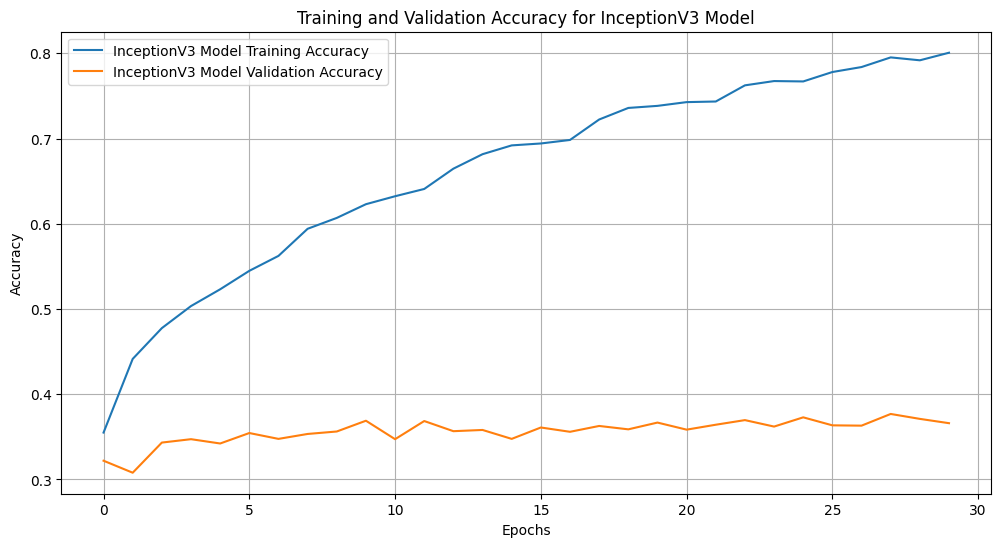

In [11]:
import matplotlib.pyplot as plt

# Plot for InceptionV3 model
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy for InceptionV3 model
plt.plot(history_inception.history['accuracy'], label='InceptionV3 Model Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='InceptionV3 Model Validation Accuracy')

# Plot configurations
plt.title('Training and Validation Accuracy for InceptionV3 Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [12]:

# ResNet152V2 model as a sub-model
input_tensor_resnet = Input(shape=input_shape, name="input_resnet")
base_model_resnet = ResNet152V2(weights='imagenet', include_top=False, input_tensor=input_tensor_resnet)
base_model_resnet.trainable = False  # Freezing the layers
x_resnet = base_model_resnet.output
x_resnet = GlobalAveragePooling2D()(x_resnet)
x_resnet = Dense(512, activation='relu')(x_resnet)


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
# VGG16 model as a sub-model
input_tensor_vgg = Input(shape=input_shape, name="input_vgg")
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor_vgg)
base_model_vgg.trainable = False  # Freezing the layers
x_vgg = base_model_vgg.output
x_vgg = GlobalAveragePooling2D()(x_vgg)
x_vgg = Dense(512, activation='relu')(x_vgg)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
